<a href="https://colab.research.google.com/github/EliperlGit/Hello-world/blob/master/notebooks/HRN_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
print(torch.__version__)

2.6.0+cu124


In [ ]:
import torch
print(torch.__version__)

2.6.0+cu124


# Step 0: Enable GPUs
First, you'll need to enable GPUs for the notebook:

*   Navigate to Edit→Notebook Settings
*   select GPU from the Hardware Accelerator drop-down

# Step 1: Installation
It takes about 30 minutes.

In [1]:
!pip install torch torchvision torchaudio
!pip install tensorflow
!pip install "modelscope[cv]" -f https://modelscope.oss-cn-beijing.aliyuncs.com/releases/repo.html
!pip install git+https://github.com/NVlabs/nvdiffrast.git
!pip install git+https://github.com/facebookresearch/pytorch3d.git

Looking in links: https://modelscope.oss-cn-beijing.aliyuncs.com/releases/repo.html
  Cloning https://github.com/NVlabs/nvdiffrast.git to /tmp/pip-req-build-nubj0jck
  Running command git clone --filter=blob:none --quiet https://github.com/NVlabs/nvdiffrast.git /tmp/pip-req-build-nubj0jck
  Resolved https://github.com/NVlabs/nvdiffrast.git to commit 729261dc64c4241ea36efda84fbf532cc8b425b8
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/facebookresearch/pytorch3d.git to /tmp/pip-req-build-1vltsp04
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-1vltsp04
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 0a59450f0ebbe12d9a8db3de937814932517633b
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch3d: filename=pytorch3d-0.7.8-cp311-cp311-linux_x86_64.whl size=60277302 sha256=0c9e21bb50bb9b1fbe994370f156a8b301fed9a931bb38758c7920fa6f186ec2
  Stored in direct

# Step 2: Model initialization
Initialize the pipeline and download the pretrained weights from modelscope.

In [2]:
import os
import cv2
from moviepy.editor import ImageSequenceClip
from modelscope.models.cv.face_reconstruction.utils import write_obj
from modelscope.outputs import OutputKeys
from modelscope.pipelines import pipeline
from modelscope.utils.constant import Tasks

face_reconstruction = pipeline(Tasks.face_reconstruction, model='damo/cv_resnet50_face-reconstruction', model_revision='v2.0.0-HRN')

  if event.key is 'enter':

2025-04-05 00:37:56,938 - modelscope - INFO - Use user-specified model revision: v2.0.0-HRN


2025-04-05 00:38:02,225 - modelscope - INFO - Use user-specified model revision: v2.0.0-HRN
2025-04-05 00:38:02,852 - modelscope - INFO - Got 19 files, start to download ...


Processing 19 items:   0%|          | 0.00/19.0 [00:00<?, ?it/s]

2025-04-05 00:38:25,954 - modelscope - INFO - Download model 'damo/cv_resnet50_face-reconstruction' successfully.
2025-04-05 00:38:26,974 - modelscope - INFO - initiate model from /root/.cache/modelscope/hub/models/damo/cv_resnet50_face-reconstruction
2025-04-05 00:38:26,975 - modelscope - INFO - initiate model from location /root/.cache/modelscope/hub/models/damo/cv_resnet50_face-reconstruction.
2025-04-05 00:38:26,977 - modelscope - INFO - initialize model from /root/.cache/modelscope/hub/models/damo/cv_resnet50_face-reconstruction


initialize network with normal
initialize network with normal


2025-04-05 00:38:30,699 - modelscope - WARNING - No preprocessor field found in cfg.
2025-04-05 00:38:30,700 - modelscope - WARNING - No val key and type key found in preprocessor domain of configuration.json file.
2025-04-05 00:38:30,701 - modelscope - WARNING - Cannot find available config to build preprocessor at mode inference, current config: {'model_dir': '/root/.cache/modelscope/hub/models/damo/cv_resnet50_face-reconstruction'}. trying to build by task and model information.
2025-04-05 00:38:30,702 - modelscope - WARNING - No preprocessor key ('face_reconstruction', 'face-reconstruction') found in PREPROCESSOR_MAP, skip building preprocessor.


UnpicklingError: FaceReconstructionPipeline: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([scalar])` or the `torch.serialization.safe_globals([scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
import os
import cv2
import torch
from moviepy.editor import ImageSequenceClip
from modelscope.models.cv.face_reconstruction.utils import write_obj
from modelscope.outputs import OutputKeys
from modelscope.pipelines import pipeline
from modelscope.utils.constant import Tasks

# Load the face reconstruction model with weights_only=False
try:
    face_reconstruction = pipeline(
        Tasks.face_reconstruction,
        model='damo/cv_resnet50_face-reconstruction',
        model_revision='v2.0.0-HRN',
        model_kwargs={'weights_only': False}  # Add this to bypass the restriction
    )
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")

# Step 3: Run

In [ ]:
def save_results(result, save_root):
    os.makedirs(save_root, exist_ok=True)

    # export obj and texture
    mesh = result[OutputKeys.OUTPUT]['mesh']
    texture_map = result[OutputKeys.OUTPUT_IMG]
    mesh['texture_map'] = texture_map
    write_obj(os.path.join(save_root, 'hrn_mesh_mid.obj'), mesh)

    # export rotation video
    frame_list = result[OutputKeys.OUTPUT]['frame_list']
    video = ImageSequenceClip(sequence=frame_list, fps=30)
    video.write_videofile(
        os.path.join(save_root, 'rotate.mp4'), fps=30, audio=False)
    del frame_list

    # save visualization image
    vis_image = result[OutputKeys.OUTPUT]['vis_image']
    cv2.imwrite(os.path.join(save_root, 'vis_image.jpg'), vis_image)

    print(f'Output written to {os.path.abspath(save_root)}')

result = face_reconstruction('https://modelscope.oss-cn-beijing.aliyuncs.com/test/images/face_reconstruction.jpg')
save_results(result, './face_reconstruction_results')

Moviepy - Building video ./face_reconstruction_results/rotate.mp4.
Moviepy - Writing video ./face_reconstruction_results/rotate.mp4



Moviepy - Done !
Moviepy - video ready ./face_reconstruction_results/rotate.mp4
Output written to /content/face_reconstruction_results


# Step 4: Visualize results

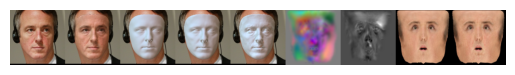

In [ ]:
from matplotlib import pyplot as plt
def vis_img(path):
  img = cv2.imread(path,-1)
  plt.imshow(img[..., ::-1])
  plt.axis("off")
  plt.show()

vis_img('./face_reconstruction_results/vis_image.jpg')